# <center>Genetic Algorithm</center>

> ### A genetic algorithm class used to predict body fat percentages from body measurements.

## Premise:
The core model is a simple neural network. It has *__p__* inputs (the same number of independent predictor variables), *__nf__* neurons in the first (and only) hidden layer, and one output. The intensity of the neurons is determined by a weighted sum of the *__p__* inputs. The magnitude of the ouput is determined as an **_equally_** weighted sum of those neuron intensities (i.e. each with weight 1/*__nf__*). This means the task of the algorithm is to find suitable weights from the inputs to the hidden layer alone to capture the complex relationships. 

Each running of the algorithm generates _**pop**_ members of a population. Each member is assigned a random set of weights, each in the range (-1,1). The quality of their predictions is measured by their fitness function, equal to 100 minus its mean quadratic error for all samples in the training set. Each member's weights are captured in binary form and collated into one long "chromosome". The fittest member then mates with all others in the population, producing progeny with chromosomes coming from their parents. More specifically each pair births two children. Each child's chromosome is a random mix of its parents' along with mutations to 5% of its bases (binary rather than the chemical quaternary of DNA). The childrens' chromosomes are then converted back to weights, with each one's fitness assessed. The fittest __*pop*__ children survive and become adults. Their elders all perish, reducing the population back to a size of *__p__*. Although, if their fittest elder is fitter than all the new adults, he/she will cheat death and become the fittest member of the population. The cycle then continues with each subsequent population producing usually fitter yet still diverse descendants. The cycle runs for a minimum number of runs. It concludes when predictions of the successors don't improve on their forebears', at which time the predictions are said to have plateued.       

## Preparation

### Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
import random as rand
import operator
import os
import time
import matplotlib.ticker as mtick
import math

### Dataset

In [17]:
data=pd.read_csv("TrainingSet.csv",header=0)
Y = data["bodyfat"]
X = data[data.columns[:5]]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

## Functions

### Sigmoid Function for Vectors

In [18]:
def sig(m):
    return 1/(1+np.exp(-m))

### FInding Fitness

For each member, the hidden layer neurons have values equally to the sigmoid of the sums of the weighted inputs. The predictions are simply the equally weighting of these neuronal firing values. The error for each sample is the square of the difference between predicted and observed value. The fitness is the percentage discrepancy of 1 and the average of these errors. 

In [19]:
def fitness(x, y, weights):
    nx = x.shape[0]
    pop = weights.shape[0]
    nf = weights.shape[2]
    weighted_sums = np.zeros((pop,nx, nf))
    y_hat = np.zeros((pop,nx))
    fitness = np.zeros((pop,1))
    error = np.zeros((pop,1))
    for member in range(pop):
        weighted_sums[member,:,:] = sig(x.dot(weights[member,:,:]))
        #   nx x nf =  nx x p x p x nf
        y_hat[member] = (1/nf)*sum(weighted_sums[member,:,:].transpose())
        error[member] = sum((y_hat[member]-y)**2)/nx
        fitness[member] = (1-error[member])*100
    fitness = np.squeeze(fitness)
    return fitness #(fitness,error,y_hat)

### Finding Chromosomes from Weights or Vice Versa

The genetic code for each member is attained as follows. First each weight is normalised to the range (0,1). Then multiplied by 1000 and rounded to integers. These are converted to binary notation using 10 binary characters. Each of these is then spliced to create one long chromosome.

In [20]:
def chromosomes(weights):
    pop = weights.shape[0]
    chromosomes = ["" for member in range(pop)]
    for member in range(pop):
        weights[member,:,:] = np.round(1000*skp.minmax_scale(weights[member,:,:].flatten()).reshape(weights.shape[1],weights.shape[2]),0)
    weights = weights.astype(int)
    for member in range(pop):
        for w in weights[member,:,:].flatten():
            chromosomes[member] += bin(w)[2:].zfill(10)
    return chromosomes

In [21]:
def chromosomes_to_weights(chromosomes, p, nf):
    pop = len(chromosomes)
    weights = ["" for r in range(pop)]
    for member in range(pop):
        weights[member] = [eval('0b'+chromosomes[member][i:i+10])/1000 for i in range(0, len(chromosomes[member]), 10)]
    weights = np.array(weights).reshape((pop,p,nf))
    for member in range(pop):
        weights[member] = skp.minmax_scale(weights[member,:,:].flatten(), feature_range=(-1, 1)).reshape(p,nf)
    return weights

### Finding Children

A crossover point is determined for each parent. Before this threshold are the bases of one parent. After it are the bases of the other. 5% of bases are then subjected to mutation (where their value is flipped).

In [22]:
def children(fitness, chr_length, adults):
    fittest = max(enumerate(fitness), key=operator.itemgetter(1))[0]
    pop = fitness.shape[0]
    cross_points = [r for r in range(-chr_length,chr_length) if r != 0]
    nm = round(chr_length*0.05)
    children = ["" for r in range((pop-1)*2)]
    baby_no = 0
    for member in [c for c in range(pop) if c != fittest]:
        for i in range(2):
            cut = rand.choice(cross_points)
            if cut < 0:
                zygote = adults[fittest][:cut] + adults[member][cut:] 
            else:
                zygote = adults[fittest][cut:] + adults[member][:cut]
            mutations = sorted(rand.sample(range(chr_length), nm), key=lambda x:x)
            children[baby_no] = zygote[:mutations[0]]
            for m in range(1,len(mutations)):
                children[baby_no] += str((int(zygote[mutations[m-1]])+1)%2) + zygote[mutations[m-1]+1:mutations[m]] 
            children[baby_no] += str((int(zygote[mutations[nm-1]])+1)%2) + zygote[mutations[nm-1]+1:]
            baby_no += 1
    return children


## Class

In [23]:
class GeneticAlgo():  
    """
    Genetic Algorithm Class
    """
    
    def __init__(self, no_functions = 10, population = 500, min_training_runs = 20, 
                 min_variance = 0.2, min_improvement = 0.005, comparison_size = 10):
        self.nf = no_functions
        self.pop = population
        self.min_runs = min_training_runs
        self.min_var = min_variance
        self.min_imp = min_improvement
        self.window = comparison_size
        self.p = None
        self.feature_range = None
        self.top_fitness = None
        self.top_fitness_chromosomes = None

    def fit(self,X_train,Y_train):
        start_time = time.time()
        self.p = X_train.shape[1]
        self.feature_range = (min(Y_train), max(Y_train))
        X_train = skp.minmax_scale(X_train)
        Y_train = skp.minmax_scale(Y_train)
        
        chromosome_length = 10*self.p*self.nf
        weights = np.random.uniform(low=-1, high=1, size=(self.pop,self.p,self.nf))
        fit_adult = fitness(X_train, Y_train, weights)
        adult_pop = chromosomes(weights)
        self.top_fitness, self.top_fitness_chromosomes = [], []
        variance = 0
        while(len(self.top_fitness) < self.min_runs or variance > self.min_var):
            child_pop = children(fit_adult,chromosome_length, adult_pop)
            weights = chromosomes_to_weights(child_pop, self.p, self.nf)
            fit_child = fitness(X_train, Y_train, weights)
        
            top_adult, top_adult_fitness = max(enumerate(fit_adult), key=operator.itemgetter(1))
            top_child_fitness = max(enumerate(fit_child), key=operator.itemgetter(1))[1]
            if top_adult_fitness > top_child_fitness:
                child_pop.append(adult_pop[top_adult])
                # top adult defies death and becomes a child again
                # at the expense of the worst child
            
            the_list = [i[0] for i in sorted(enumerate(fit_child.tolist()), key=lambda x:x[1])]
            the_list = the_list[len(the_list)-self.pop:len(the_list)]
            adult_pop = operator.itemgetter(*the_list)(child_pop)
            # top population of children survive to become adults
            weights = chromosomes_to_weights(adult_pop, self.p, self.nf)
            fit_adult = fitness(X_train, Y_train, weights)
               
            self.top_fitness += [top_adult_fitness]
            self.top_fitness_chromosomes += [adult_pop[top_adult]]
        
            if len(self.top_fitness) >= self.min_runs:
                last_few = self.top_fitness[len(self.top_fitness)-self.window-1:len(self.top_fitness)-1]
                variance = np.var(last_few)
                if top_adult_fitness <= max(last_few)*self.min_imp:
                    break
        if top_adult_fitness <= max(last_few)*self.min_imp:
            print("Reason for stopping: Fitness was not improving.\n(Fitness: %s <= Minimum Fitness: %s)\nRan %s times." 
                  % (top_adult_fitness,max(last_few)*self.min_imp,len(self.top_fitness)))
        else:
            print("Reason for stopping: Variance of predictions was too low.\n(Variance: %s <= Minimum Variance: %s)\nRan %s times." 
                  % (variance,max(last_few)*self.min_var,len(self.top_fitness)))
    
        print("Took %s minutes." % (round(time.time()*(1/60)-start_time*(1/60),1)))
        
    def predict(self,X_test_data,Y_test_data):
        nx = X_test_data.shape[0]
        X_test_data = skp.minmax_scale(X_test_data)
        Y_test_data = skp.minmax_scale(Y_test_data)
        best_genes = self.top_fitness_chromosomes[max(enumerate(self.top_fitness), key=operator.itemgetter(1))[0]]
        w = [eval('0b'+best_genes[i:i+10])/1000 for i in range(0, len(best_genes), 10)]
        w = skp.minmax_scale(np.array(w).flatten(), feature_range=(-1, 1)).reshape(self.p,self.nf)
        weight_sums = np.zeros((nx, self.nf))
        y_hat = np.zeros((nx,1))
        weight_sums = sig(X_test_data.dot(w))
        #   nx x nf =  nx x p x p x nf
        y_hat = 0.2*sum(weight_sums.transpose())
        error = sum((y_hat-Y_test_data)**2)/nx
        fitness = (1-error)*100
        y_hat = skp.minmax_scale(y_hat, feature_range=self.feature_range)
        return (y_hat, fitness, error)
    
    def change_in_fitness(self,X_test_data,Y_test_data):
        X_test_data = skp.minmax_scale(X_test_data)
        Y_test_data = skp.minmax_scale(Y_test_data)
        w = chromosomes_to_weights(self.top_fitness_chromosomes,self.p,self.nf)
        f = fitness(X_test_data, Y_test_data, w)
        return f

### Dials
**no\_functions** = _**nf**_ 

**population** = _**pop**_ 

When fitting to the training set, the program runs for at least **min\_training\_runs**. After this, it compares the predictors from the last **comparison\_size** fittest members of the population. If the variance of these predictions is below **min\_variance**, or the latest fittest member is less than **min\_improvement** percent fitter than his/her last **comparison\_size** forebears, then the predictions have platueaued. The population is deemed sufficiently homogenous. As such, the fitting halts.

### Other Things of Note
When fitting the program normalises the training data and scales its predictions back using scaling of the training set.
For each run, the fitness values of the fittest in each generation is recorded, along with their chromosome. 

## Using the Genetic Class

### Default values
**no_functions** = 10, **population** = 500, **min_training_runs** = 20, 
**min_variance** = 0.2, **min_improvement** = 0.005, **comparison_size** = 10

### Fitting

In [24]:
genie = GeneticAlgo(min_training_runs = 100,  min_variance = 0.001, min_improvement = 0, )
genie.fit(x_train,y_train)

Reason for stopping: Variance of predictions was too low.
(Variance: 0.0009268453436406764 <= Minimum Variance: 0.09809279559281928)
Ran 100 times.
Took 1.9 minutes.


### Record Predictions

In [25]:
predictions = genie.predict(x_test,y_test)

### Scatterplot of Fitness by Generation (or Iteration)

C:\Users\Luke\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


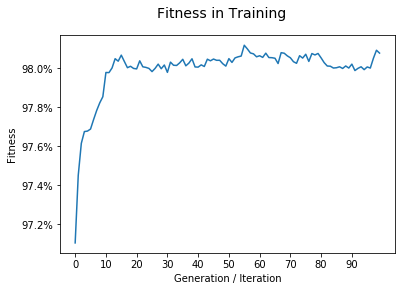

In [26]:
iteration = [i for i in range(len(genie.top_fitness))]
fig = plt.figure()
plt.plot(iteration, genie.top_fitness)
fig.suptitle('Fitness in Training', fontsize=14)
plt.xlabel('Generation / Iteration', fontsize=10)
plt.ylabel('Fitness', fontsize=10)
fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax = fig.add_subplot(1,1,1)
ax.yaxis.set_major_formatter(yticks)
xint = range(min(iteration), math.ceil(max(iteration))+1, 10)
plt.xticks(xint)
plt.show()

### 3D Scatterplot
It shows how body fat percentages change with height and weight. It also compared these observations with what the model predicted.

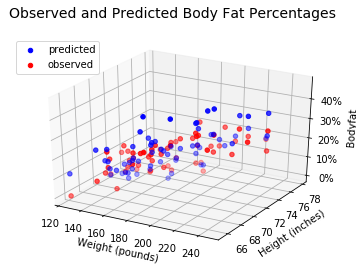

In [27]:
fig = plt.figure()
fig.suptitle('Observed and Predicted Body Fat Percentages', fontsize=14)
ax = plt.subplot(111, projection='3d')
ax.scatter(x_test[x_test.columns[0]], x_test[x_test.columns[1]], predictions[0],color="blue",label="predicted")
ax.scatter(x_test[x_test.columns[0]], x_test[x_test.columns[1]], y_test,color="red",label="observed")
#ax.scatter(x_test[x_test.columns[0]].tolist(), x_test[x_test.columns[1]].tolist(), predictions[0].tolist())
ax.set_zlabel('Bodyfat', fontsize=10)
ax.set_xlabel('Weight (pounds)', fontsize=10)
ax.set_ylabel('Height (inches)', fontsize=10)
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
zticks = mtick.FormatStrFormatter(fmt)
ax.zaxis.set_major_formatter(zticks)
plt.legend(loc = 'upper left')
plt.show()

In [28]:
print("Overall average squared error on the test data is %s, so roughly %s cm off on each prediction." % (round(sum((y_test-predictions[0])**2)/predictions[0].shape[0],2),round((sum((y_test-predictions[0])**2)/predictions[0].shape[0])**(0.5),2)))

Overall average squared error on the test data is 56.0, so roughly 7.48 cm off on each prediction.
